In [1]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from collections import Counter
from scipy import stats
import requests
import random

Mutations that appear many times over course of natural evoltion of SARS-CoV-2 and are inherited by a descending clade (don't just die out) could be beneficial. They are likely neutral at worst. Look for mutations driving clade success by finding mutations that occur repeatedly and result in high logisitic growth rates and high numbers of S1 mutations each time

Start by finding the number of independent times each mutation occurs and doesn't die out (forms a resulting clade of at least 10 tips)


In [157]:
tree_url = 'https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution.json'

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

In [158]:
# #Download tree json
# tree_url = "https://data.nextstrain.org/ncov_global_2021-05-19.json"
# # tree_url = "https://data.nextstrain.org/ncov_gisaid_global.json"

# tree_json = requests.get(tree_url).json()

# #Put tree in Bio.Phylo format
# tree = json_to_tree(tree_json)

Download and unzip the most recent sequence file from within `nextstrain/ncov` using the following commands and copy the sequence file to `nextstrain/adaptive-evolution`

aws s3 cp s3://nextstrain-ncov-private/global_subsampled_sequences.fasta.xz .

unxz global_subsampled_sequences.fasta.xz

In [3]:
# sequences_file = 'global_subsampled_sequences.fasta'
# record_dict = SeqIO.to_dict(SeqIO.parse(sequences_file, "fasta"))

Read in reference sequence

This is the Genbank reference file used by Nextstrain, except edited to contain location information for S1, S2, and RdRp

In [3]:
# make dictionary with gene name as key and reference sequence of that gene as value

reference_sequence = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    for feature in record.features:
        if feature.type == 'CDS':
            gene_seq = feature.location.extract(record.seq).translate()
            reference_sequence[feature.qualifiers['gene'][0]] = gene_seq


/Users/katekistler/anaconda3/envs/ncov/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [104]:
def count_independent_occurrences(mutation_type='aa'):
    
    """
    Function to determine all mutations that occur on internal branches of the phylogeny. 
    Only branches with at least 10 descendents are used in order to reduce the impact of 
    sequencing error and phylogenetic reconstruction (seen mostly at tips) on this analysis
    
    `mutation_type` can be set to 'aa' (to look at specific amino acid substitution) 
    or 'site' (to look at any nonsynonymous substitution that happens at a specific residue)
    
    returns `all_mutations_unique`: a list of all mutations seen on internal branches and
    `independent_occurrences_all_mutations`: a dictionary with each observed mutation as a key, 
    and the number of times that mutation occurs on internal branches as the value of that key.
    """
    
    all_mutations = []


    #only look at mutations on internal branches
    for node in tree.find_clades(terminal=False):
        
        # only consider mutations on branches that give rise to a clade of at least 10 tips
        if len(node.get_terminals())>=15:

            if hasattr(node, 'branch_attrs'):
                for gene, mut_list in node.branch_attrs["mutations"].items():
                    # not considering synonymous mutations for now
                    if gene!= 'nuc':
                        for mut in mut_list:
                            
                            if mutation_type == 'aa':
                                # look at specific nonsyn muts
                                gene_mutation = f'{gene}:{mut}'

                                
                            elif mutation_type == 'site':
                                # look at mutation to a codon (without regard to identity of mutation)
                                gene_mutation = f'{gene}:{mut[1:-1]}'
                                
                            
                            # append mutation to a list of all observed mutations
                            # exclude if mutation is in stop codon position of gene
                            if int(mut[1:-1])!=len(reference_sequence[gene]):
                                all_mutations.append(gene_mutation)
                


    all_mutations_unique = list(set(all_mutations))    

    independent_occurrences_all_mutations = Counter(all_mutations)
    

    return all_mutations_unique, independent_occurrences_all_mutations


Plot a histogram of the number of independent times a mutation appears in the natural history of the virus. Just for interest, not to be included in the figure

In [20]:
def histogram_of_occurrences(mutation_type='aa', filename=None):
    
    all_mutations_unique, independent_occurrences_all_mutations = count_independent_occurrences(mutation_type)
    

    df = pd.DataFrame([{"mutation": mutation, "independent_occurrences": value} 
                       for mutation, value in independent_occurrences_all_mutations.items()])
    
    print(len(df[df['independent_occurrences']>=5])/len(df['independent_occurrences']))
    
    
    fig, ax = plt.subplots(figsize=(7, 3))
    sns.histplot(x = 'independent_occurrences', data = df, ax=ax, discrete=True, 
                 color="#70c3b0", edgecolor="#ABABAB")
    
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.set_ylabel('Count', size=12)
    ax.set_xlabel('Independent Occurrences', size=12)
    
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

0.02109704641350211


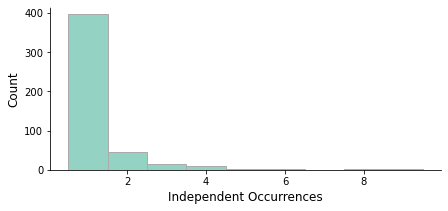

In [72]:
histogram_of_occurrences()

For each clade: 
1. find the number of S1 muts and the logistic growth rate
2. find all mutations that happened on path from root to clade
3. for each mutation in (2), add the values from (1) to a list. 

Over all clades, the result will be a dictionary where each observed mutation is a key and the values are the logistic growth rates of all clades that descend from the observed mutation. 

In [7]:
def get_parent(tree, child_clade):
    """
    Function that returns the path from root to specified clade
    """
    node_path = tree.get_path(child_clade)
    return node_path

In [105]:
def clades_descending_from_mut(all_mutations_unique, mutation_type='aa'):
    """
    Function to determine all clades that descend from a particular mutation. 
    Walks through all internal branches of the tree and determines all mutations 
    that happened along the path from the root of the tree. The number of 
    s1 mutations and the logisitic growth rate at this internal branch are stored 
    as attributes of descendents of each of the mutations that precede the clade
    
    Takes a list of all mutations observed on internal branches (`all_mutations_unique`) 
    as input 
    
    Returns `growth_by_precedingmut_dict` and `s1muts_by_precedingmut_dict`, 
    dictionaries with keys being every internal mutation and values being a list of 
    logistic growth rates and s1 mutations observed in descending clades, respectively
    """

    #initialize dict for storing all growth rates observed in clades descending from {key} mutation
    growth_by_precedingmut_dict = {k:[] for k in all_mutations_unique}


    #initialize dict for storing S1 mutation counts observed in clades descending from {key} mutation
    s1muts_by_precedingmut_dict = {k:[] for k in all_mutations_unique}



    for node in tree.find_clades(terminal=False):
        
        # still only considering branches that give rise to a clade of at least 10
        if len(node.get_terminals())>=15:
        
            node_path = get_parent(tree, node)


            s1_mutations = None
            if "S1_mutations" in node.node_attrs:
                s1_mutations = node.node_attrs["S1_mutations"]["value"]


            logistic_growth = None
            if "logistic_growth" in node.node_attrs:
                logistic_growth = node.node_attrs["logistic_growth"]["value"]


            for parent in node_path[:-1]:
                if hasattr(parent, 'branch_attrs'):
                    for gene, mut_list in parent.branch_attrs["mutations"].items():
                        if gene!= 'nuc':
                            for mut in mut_list:

                                if mutation_type == 'aa':
                                    # look at specific nonsyn muts
                                    gene_mutation = f'{gene}:{mut}'


                                elif mutation_type == 'site':
                                    # look at mutation to a codon (without regard to identity of mutation)
                                    gene_mutation = f'{gene}:{mut[1:-1]}'
                                    


                                # exclude mutations to last codon of gene (stop codon)
                                if int(mut[1:-1])!=len(reference_sequence[gene]):

                                    if logistic_growth!=None:
                                        growth_by_precedingmut_dict[gene_mutation].append(logistic_growth)

                                    if s1_mutations!=None:
                                        s1muts_by_precedingmut_dict[gene_mutation].append(s1_mutations)
                                        
    # get rid of empty entries
    growth_by_precedingmut_dict = {k:v for k,v in growth_by_precedingmut_dict.items() if v}
    s1muts_by_precedingmut_dict = {k:v for k,v in s1muts_by_precedingmut_dict.items() if v}
    
    
    return growth_by_precedingmut_dict, s1muts_by_precedingmut_dict


Find the average logisitic growth rate after a mutation by finding the mean growth rate of all clades descending from branches with that mutation. Do the same for number of S1 mutations.

Then, make a dataframe where each row is a mutation and columns contain number of independent occurrences, average growth rates, and number of S1 mutations.

In [9]:
def calc_mean_rate_and_s1_muts(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict):
    """
    Determines the mean number of S1 mutations and logistic growth rates of clades 
    that descend from each mutation observed on internal branches of the phylogeny
    
    Returns dictionaries with keys as mutations and values as the mean values of 
    growth rate and s1 mutations
    """
    
    # to consider: clade nesting-> just take unique values? 
    # Here, all nested clades are averaging, giving more weight to larger clades
    growth_by_precedingmut_mean = {k:(sum(v)/len(v)) for k,v in growth_by_precedingmut_dict.items()}

    # Here, only unique values are taken, to limit the effect of nesting clades
    growth_by_precedingmut_limit_nesting = {k:list(set(v)) for k,v in growth_by_precedingmut_dict.items()}
    growth_by_precedingmut_limit_nesting_mean = {k:(sum(v)/len(v)) for k,v in growth_by_precedingmut_limit_nesting.items()}

    # this will give more weight to larger clades
    s1muts_by_precedingmut_mean = {k:(sum(v)/len(v)) for k,v in s1muts_by_precedingmut_dict.items() if len(v)!=0}

#     return  growth_by_precedingmut_mean, s1muts_by_precedingmut_mean
    return growth_by_precedingmut_limit_nesting_mean, s1muts_by_precedingmut_mean

In [10]:
def convergent_evo_dataframe(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict, 
                             independent_occurrences_all_mutations, mutation_type='aa'):
    
    """
    Makes a dataframe where each row is a mutation seen on internal branches of the 
    phylogeny and columns store information about the number of times that mutation 
    occurs across the phylogeny, as well as mean growth rate and mean number of s1 
    mutations in descending clades. Manually consolidates common deletion mutations 
    that span multiple residues into one mutation event
    
    Returns this dataframe.
    """
    
    growth_by_precedingmut_mean, s1muts_by_precedingmut_mean = calc_mean_rate_and_s1_muts(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict)
    
    # make dataframe where each row is a mutation
    # and columns contain number of independent occurrences, average growth rates, and number of S1 mutations

    convergent_evo_list = []

    for mut, occurrences in independent_occurrences_all_mutations.items():
        if mut in s1muts_by_precedingmut_mean.keys():
            avg_s1_muts = s1muts_by_precedingmut_mean[mut]
        else:
            avg_s1_muts = None

        if mut in growth_by_precedingmut_mean.keys():
            avg_growth = growth_by_precedingmut_mean[mut]
        else:
            avg_growth = None



        # for deletions that span multiple consecutive residues, condense this into one row
        if mut == 'ORF1a:S3675-': 
            mut = 'ORF1a:3675/3676/3677del'


        elif mut == 'S:H69-':
            mut = 'S:69/70del'

        if mut not in ['ORF1a:G3676-', 'ORF1a:F3677-', 'S:V70-']:
            convergent_evo_list.append({'mutation': mut, 'independent_occurrences': occurrences, 
                                        'avg_s1_muts': avg_s1_muts, 'avg_growth': avg_growth
                                       })

    convergent_evo_df = pd.DataFrame(convergent_evo_list)


    # multiply occurrences times growth
    convergent_evo_df['occurrences_times_growth']= convergent_evo_df['independent_occurrences']*convergent_evo_df['avg_growth']

    
    return convergent_evo_df


In [106]:
def mean_rate_on_tree():
    """
    Finds the mean growth rate of all clades on the tree. 
    Limit nesting, as is done for mutation calculation, by 
    removing duplicate growth rate values
    """
    
    all_growth_rates = []
    for node in tree.find_clades(terminal=False):
        
        # still only considering branches that give rise to a clade of at least 10
        if len(node.get_terminals())>=15:
            if "logistic_growth" in node.node_attrs:
                all_growth_rates.append(node.node_attrs["logistic_growth"]["value"])
                
    all_growth_rates_limit_nesting = list(set(all_growth_rates))
    mean_growth_rate = sum(all_growth_rates_limit_nesting)/len(all_growth_rates_limit_nesting)
    
    return mean_growth_rate


# Fig3a: mutations that occur many times over the phylogeny and result in a high rate of growth each time might be adaptive

#### Plot number of occurrences versus average logisitic growth rate for each mutation. Zoom into the mutations that occur most often and label them

In [111]:
def fig3a_occurrences_vs_growth(date_text=None, mutation_type='aa', min_occurrences = 4, plot=True, filename=False):
    """
    Function to plot each mutation as a point in a scatterplot, with x-axis being the 
    number of times this mutation occurred across the phylogeny and the y-axis being 
    the average logistic growth rate of descending clades
    """
    
    all_mutations_unique, independent_occurrences_all_mutations = count_independent_occurrences(mutation_type)
    
    growth_by_precedingmut_dict, s1muts_by_precedingmut_dict = clades_descending_from_mut(all_mutations_unique, mutation_type)
    
    convergent_evo_df = convergent_evo_dataframe(growth_by_precedingmut_dict, s1muts_by_precedingmut_dict, 
                                                 independent_occurrences_all_mutations, mutation_type)
    
    # get rid of any entries that have NaN values for growth or s1 mutations
    convergent_evo_df = convergent_evo_df.dropna()
    
    # take a subset of the data, only including mutations that appear `min_occurrences` of more times
    convergent_evo_df_zoom = convergent_evo_df.loc[convergent_evo_df['independent_occurrences']>=min_occurrences
                                                  ].reset_index()
    
    if mutation_type =='aa':
        convergent_evo_df_zoom['mutation_location'] = convergent_evo_df_zoom.apply(lambda row: 
                                                                          'S1' if row['mutation']== 'S:69/70del'
                                                                          else 'S1' if row['mutation'][0]=='S' 
                                                                                   and int(row['mutation'].split(':')[1][1:-1])<=685
                                                                                   and int(row['mutation'].split(':')[1][1:-1])>=13
                                                                          else 'other', 
                                                                          axis=1)
    elif mutation_type == 'site':
        convergent_evo_df_zoom['mutation_location'] = convergent_evo_df_zoom.apply(lambda row: 
                                                                          'S1' if row['mutation'][0]=='S' 
                                                                                   and int(row['mutation'].split(':')[1])<=685
                                                                                   and int(row['mutation'].split(':')[1])>=13
                                                                          else 'other', 
                                                                          axis=1)
    
    # allow plotting to be toggled off to just return a list of top_scoring_muts
    if plot == False:

        top_scoring_muts = []
        for i in range(convergent_evo_df_zoom.shape[0]):
            top_scoring_muts.append({'mutation':convergent_evo_df_zoom.mutation[i], 
                                     'rate': convergent_evo_df_zoom.avg_growth[i], 
                                     'num_occurrences': convergent_evo_df_zoom.independent_occurrences[i], 
                                     'mutation_location': convergent_evo_df_zoom.mutation_location[i]})
        
        top_scoring_muts_df = pd.DataFrame(top_scoring_muts)
        return top_scoring_muts_df
    
    
    
    elif plot == True:

    
        # two subplots: one showing all mutations, 
        # and one zoomed in to the mutations with highest values on both axes
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,6), gridspec_kw={'width_ratios': [1.5, 5]})

        cmap1 = {'S1':"#4770eb",'other':"#ff5e31"}

        sns.scatterplot(x='independent_occurrences', y='avg_growth', 
                        data=convergent_evo_df, ax=ax1, alpha=0.3,
                        color='#888888', legend = False)

        # find the "avg_growth" range of all mutations with at least `min_occurrences`
        max_growth = convergent_evo_df[convergent_evo_df['independent_occurrences']>=min_occurrences]['avg_growth'].max()
        min_growth = convergent_evo_df[convergent_evo_df['independent_occurrences']>=min_occurrences]['avg_growth'].min()


        # find max number of occurrences
        max_occurrences = convergent_evo_df['independent_occurrences'].max()


        sns.scatterplot(x='independent_occurrences', y='avg_growth', 
                        data=convergent_evo_df_zoom, ax=ax2, s=100,
                        hue = 'mutation_location', hue_order=['S1', 'other'],
                        palette=cmap1, zorder=1)
        

        ax1.set_xlim(0, (max_occurrences + 1.0))
        ax1.set_xlabel('Independent occurrences of mutation', fontsize = 12)
        ax1.set_ylabel('Mean Logisitic Growth Rate of Descending Clades', fontsize = 12)

        ax2.set_ylim((min_growth - 1), (max_growth + 1))
        ax2.set_xlim((min_occurrences - 0.5), (max_occurrences + 0.75))
        ax2.set_xlabel('', fontsize = 12)
        ax2.set_ylabel('', fontsize = 12)
        ax2.set_title(date_text, fontsize=14)

        ax1.add_patch(
            patches.Rectangle(
                xy=((min_occurrences - 0.5), (min_growth - 1)),  # point of origin.
                width=(max_occurrences - min_occurrences + 1),
                height= (max_growth - min_growth + 2),
                linewidth=1,
                color='#ffcec1',
                fill=False
            )
        )
        
        # add horizontal line showing the mean growth rate of all clades on tree
        mean_growth_rate = mean_rate_on_tree()
        
        ax2.axhline(mean_growth_rate, color='#ffcec1', lw=2, linestyle='--')


        ax1.spines['top'].set_color('white')
        ax1.spines['right'].set_color('white')
        
        ax2.spines['bottom'].set_color('#ffbeac')
        ax2.spines['top'].set_color('#ffbeac')
        ax2.spines['left'].set_color('#ffbeac')
        ax2.spines['right'].set_color('#ffbeac')
        
        plt.xticks(fontsize= 12)
        plt.yticks(fontsize= 12)

        # manually move some of the labels to make more legible
        for i in range(convergent_evo_df_zoom.shape[0]):
            label_gene = convergent_evo_df_zoom.mutation[i].split(':')[0]
            if mutation_type == 'aa':
                label_mut = convergent_evo_df_zoom.mutation[i].split(':')[1][1:]
            elif mutation_type == 'site':
                label_mut = convergent_evo_df_zoom.mutation[i].split(':')[1]
            label = f'{label_gene}:{label_mut}'
            if convergent_evo_df_zoom.mutation[i] == 'ORF1a:3675/3676/3677del':
                label = 'ORF1a:3675-3677del'
            elif convergent_evo_df_zoom.mutation[i] == 'S:69/70del':
                label = 'S:69/70del'
            elif convergent_evo_df_zoom.mutation[i] == 'ORF1a:3675':
                label = 'ORF1a:3675-3677'
            
            #manually specify adjustments to make labels legible
            adjustments = {'ORF1a:3675-3677del':{'x':-0.6, 'y':+0.45}, 
                           'S:501Y':{'x':0.075, 'y':+0.7}, 'ORF9b:10S':{'x':0.075, 'y':-0.8}, 
                           'S:18F':{'x':0.075, 'y':+0.8}, 'S:681H':{'x':0.075, 'y':-1.0}, 
                           'S:144-':{'x':0.075, 'y':+0.5}, 'N:13L':{'x':0.075, 'y':+0.2}}
                
            if convergent_evo_df_zoom.mutation[i] not in ['ORF1a:3676','ORF1a:3677']: 
                if label in adjustments.keys():
                    adjust_x = adjustments[label]['x']
                    adjust_y = adjustments[label]['y']
                else:
                    adjust_x = 0.075
                    adjust_y = -0.2
                ax2.text(x=convergent_evo_df_zoom.independent_occurrences[i]+adjust_x,
                         y=convergent_evo_df_zoom.avg_growth[i]+adjust_y,
                         s=label, 
                         ha='left',
                         fontdict=dict(color='black',size=10, rotation=0))

                
    handles, labels = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles, labels, title='Mutation Location')
    
    plt.figtext(0.04, 0.9, 'A', fontsize=24, fontweight='bold')
    
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

    

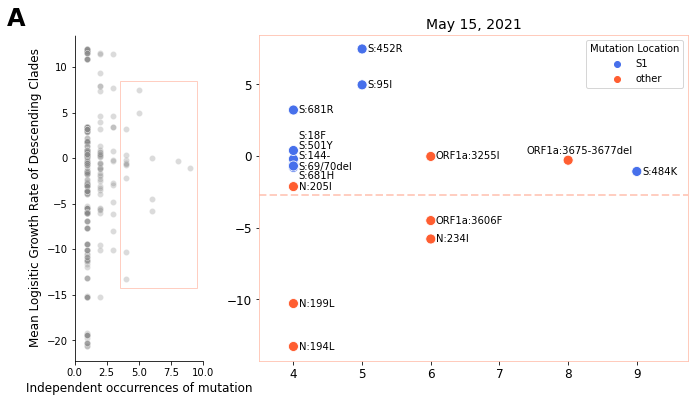

In [112]:
#new 
fig3a_occurrences_vs_growth(date_text='May 15, 2021')

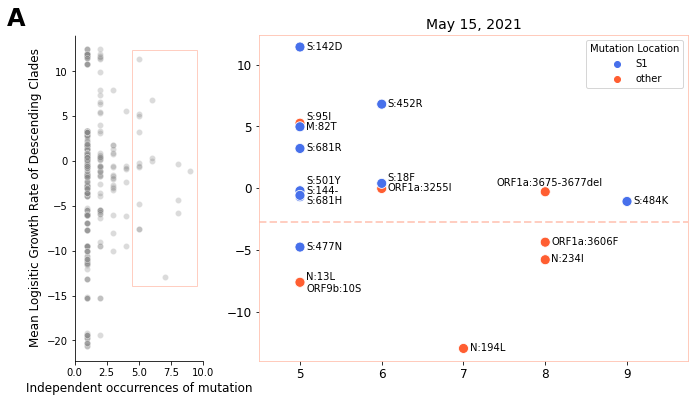

In [48]:
#new 
fig3a_occurrences_vs_growth('May 15, 2021')

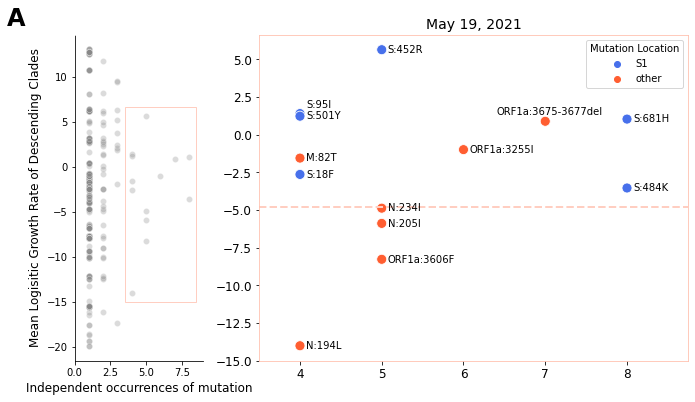

In [277]:
#5-19
fig3a_occurrences_vs_growth(filename='plots/fig3a_20210519.png')

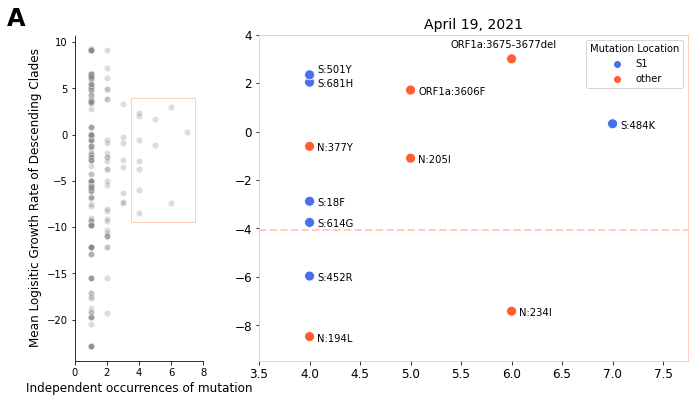

In [272]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global_2021-04-19.json"
# tree_url = "https://data.nextstrain.org/ncov_gisaid_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

fig3a_occurrences_vs_growth(filename='plots/fig3supp_1monthbefore.png')

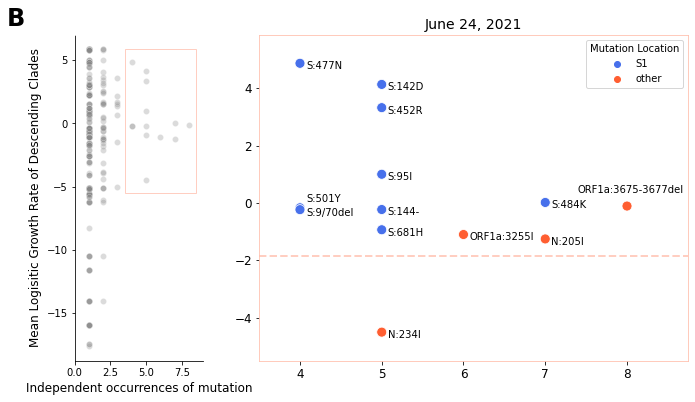

In [270]:
#Download tree json
tree_url = "https://data.nextstrain.org/ncov_global_2021-06-24.json"
# tree_url = "https://data.nextstrain.org/ncov_gisaid_global.json"

tree_json = requests.get(tree_url).json()

#Put tree in Bio.Phylo format
tree = json_to_tree(tree_json)

fig3a_occurrences_vs_growth(filename='plots/fig3supp_1monthafter.png')

Now randomize the mutations on the tree to make a null expectation for average growth rate given a certain number of independent occurrences

In [80]:
def expected_growth_on_randomized_tree(num_iterations):
    """
    Function to randomize the mutations on the tree 
    and return a dataframe with the number of times each mutation 
    occurs and the average growth rate of descending clades
    """
    
    all_mutations_unique, independent_occurrences_all_mutations = count_independent_occurrences(mutation_type='aa')
    
    # make list of all nonsynonymous mutations observed on internal branches of tree 
    # to be placed on tree at random
    bag_of_mutations = [mut for mut,x in independent_occurrences_all_mutations.items() for y in range(x)]
    
    possible_occurrences = list(set(independent_occurrences_all_mutations.values()))
    mean_growth_by_num_occurrences = []

    for i in range(int(num_iterations)):
        # randomize positions of mutations on tree
        randomized_tree = randomize_tree(bag_of_mutations)

        # all_mutations_unique will be the same for randomized and empirical data
        growth_by_precedingmut_dict_random, s1muts_by_precedingmut_dict_random = clades_descending_from_randomized_mut(all_mutations_unique, randomized_tree)
        
        growth_by_precedingmut_mean_random, s1muts_by_precedingmut_mean_random = calc_mean_rate_and_s1_muts(growth_by_precedingmut_dict_random, s1muts_by_precedingmut_dict_random)


        for mut, rate in growth_by_precedingmut_mean_random.items():
            num_occurrences = independent_occurrences_all_mutations[mut]

            mean_growth_by_num_occurrences.append({'num_occurrences':num_occurrences, 'rate': rate})


    df = pd.DataFrame(mean_growth_by_num_occurrences)
    return df

In [81]:
def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    
    without_deletions = [x for x in mutation_list if x[-1]!='-' and x[0]!='-']
    #consolidate deletions and reversions
    deletions_only = [x for x in mutation_list if x[-1]=='-' or x[0]=='-']
    deletions_only.sort(key=lambda x:x[1:-1])
    
    
    #keep track of start of separate deletions
    separate_deletions = []

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        separate_deletions.append(deletions_only[0])

        deletion_tracker = int(deletions_only[0][1:-1])
        
        for deletion in deletions_only[1:]:

            deleted_pos = int(deletion[1:-1])
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                separate_deletions.append(deletion)
            deletion_tracker = deleted_pos
    
    consolidated_mutation_list = separate_deletions + without_deletions
            
    return consolidated_mutation_list

In [82]:
def remove_duplicate_mutations(mutation_list):
    """
    Function to find duplicates in mutation list 
    and keep only one instance of the duplicated mutation
    """
    mutation_list = list(mutation_list)
    seen = {}
    dupes = []

    for x in mutation_list:
        if x not in seen:
            seen[x] = 1
        else:
            if seen[x] >= 1:
                dupes.append(x)
            seen[x] += 1

    nondupe_list = [x for x in seen.keys()]
    
    return nondupe_list, dupes

In [83]:
def remove_ancestral_muts(list_of_muts, node):
    # need to check that these mutation haven't already occurred on ancestors of this branch
    node_path = get_parent(tree, node)[:-1]

    dont_use = []
    for mut in list_of_muts:
        for parent in node_path:
            if mut in parent.random_muts:
                dont_use.append(mut)
    
    
    list_of_muts_edited = [x for x in list_of_muts if x not in dont_use]

    return list_of_muts_edited, dont_use

In [107]:
def count_muts_per_branch():
    # find distribution of muts on branch
    mut_counts = []

    for node in tree.find_clades():

        # still only considering branches that give rise to a clade of at least 10
        if len(node.get_terminals())>=15:

            if hasattr(node, 'branch_attrs'):
                mut_count = 0
                for gene, mut_list in node.branch_attrs["mutations"].items():

                    # not considering synonymous mutations for now
                    if gene!= 'nuc':
                        for mut in mut_list:

                            # append mutation to a list of all observed mutations
                            # exclude if mutation is in stop codon position of gene
                            if int(mut[1:-1])!=len(reference_sequence[gene]):
                                mut_count+=1

                mut_counts.append(mut_count)

    return mut_counts

In [108]:
def randomize_tree(bag_of_mutations):
    # shuffle the bag of mutations
    shuffled_bag_of_muts = np.random.choice(bag_of_mutations, len(bag_of_mutations), replace = False)

    mut_counts = count_muts_per_branch()
    
    # shuffle the list of number of mutations per node
    shuffled_muts_per_branch = np.random.choice(mut_counts, len(mut_counts), replace = False)
    

    for node in tree.find_clades():

        # add attribute for randomized muts
        node.random_muts = []

        # still only considering branches that give rise to a clade of at least 10
        if len(node.get_terminals())>=15:

            # randomly choose the number of mutations that should occur on branch
            num_muts_on_branch = shuffled_muts_per_branch[-1:][0]
            # then remove this value from the list
            shuffled_muts_per_branch = shuffled_muts_per_branch[:-1]


            if num_muts_on_branch != 0:

                # randomly choose that many mutations to throw on this node. Without replacement
                randomized_muts = shuffled_bag_of_muts[-num_muts_on_branch:]
                # then remove the chosen muts from the bag
                shuffled_bag_of_muts = shuffled_bag_of_muts[:-num_muts_on_branch]

                # edit the list of random mutations if the mutations are found an the ancestor of this node 
                # or if there are duplicates

                # initialize list of mutations that will not be added to this node 
                # and which should be added back to the bag
                add_back_to_bag = []

                for i in range(100):
                    randomized_muts, dont_use = remove_ancestral_muts(randomized_muts, node)
                    if len(dont_use) != 0:
                        randomized_muts+=(x for x in shuffled_bag_of_muts[-len(dont_use):])
                        # remove the newly chosen muts from the bag
                        shuffled_bag_of_muts = shuffled_bag_of_muts[:-len(dont_use)]
                        # add unused mutations back to bag
                        add_back_to_bag+=dont_use

                    randomized_muts, dupes = remove_duplicate_mutations(randomized_muts)
                    if len(dupes) != 0:
                        randomized_muts+=(x for x in shuffled_bag_of_muts[-len(dupes):])
                        # remove the newly chosen muts from the bag
                        shuffled_bag_of_muts = shuffled_bag_of_muts[:-len(dupes)]
                        # add unused mutations back to bag
                        add_back_to_bag+=dupes

                    if len(dont_use) == 0 and len(dupes) == 0:
                        break



                # add the duplicates back into the bag
                np.append(shuffled_bag_of_muts, np.array(add_back_to_bag))


                random.shuffle(shuffled_bag_of_muts)

                # add the random mutations to this node
                node.random_muts = randomized_muts
                
    return tree


In [109]:
def clades_descending_from_randomized_mut(all_mutations_unique, randomized_tree):

    #initialize dict for storing all growth rates observed in clades descending from {key} mutation
    growth_by_precedingmut_dict = {k:[] for k in all_mutations_unique}


    #initialize dict for storing S1 mutation counts observed in clades descending from {key} mutation
    s1muts_by_precedingmut_dict = {k:[] for k in all_mutations_unique}



    for node in randomized_tree.find_clades():
        
        # still only considering branches that give rise to a clade of at least 10
        if len(node.get_terminals())>=15:
        
            node_path = get_parent(tree, node)


            s1_mutations = None
            if "S1_mutations" in node.node_attrs:
                s1_mutations = node.node_attrs["S1_mutations"]["value"]


            logistic_growth = None
            if "logistic_growth" in node.node_attrs:
                logistic_growth = node.node_attrs["logistic_growth"]["value"]


            for parent in node_path[:-1]:
                for gene_mutation in node.random_muts:
                    
                    if logistic_growth!=None:
                        growth_by_precedingmut_dict[gene_mutation].append(logistic_growth)

                    if s1_mutations!=None:
                        s1muts_by_precedingmut_dict[gene_mutation].append(s1_mutations)
                                        
    # get rid of empty entries
    growth_by_precedingmut_dict = {k:v for k,v in growth_by_precedingmut_dict.items() if v}
    s1muts_by_precedingmut_dict = {k:v for k,v in s1muts_by_precedingmut_dict.items() if v}
    
    
    return growth_by_precedingmut_dict, s1muts_by_precedingmut_dict

# Fig3b: certain mutations result in higher than expected average growth rates

#### Plot the expectated relationship between occurrences and logistic growth rate as a gray boxplot, with empirical datapoints that exceed the 90th percentile of expectation shown and labeled

In [125]:
def fig3b(num_iterations, filename=False):

    random_rates_df = expected_growth_on_randomized_tree(num_iterations)
    
    all_num_occurrences = list(set(random_rates_df.num_occurrences))
    
    fig, ax = plt.subplots(figsize=(11,4))

    sns.boxplot(x='num_occurrences', y='rate', data=random_rates_df, 
                  dodge=True, zorder=1, order=[i for i in range(all_num_occurrences[0], all_num_occurrences[-1]+1)],
                  color='#ededed', ax=ax)
    
    empirical_df = fig3a_occurrences_vs_growth(plot=False)
    
    # have to adjust the num_occurrences to zero-based
    empirical_df['num_occurrences'] = empirical_df['num_occurrences']-1
    
    # for each empirical mutation, find percentile of expected data
    percentiles = []
    for k,v in empirical_df.iterrows():
        percentile = stats.percentileofscore(list(
            random_rates_df[random_rates_df['num_occurrences']==v['num_occurrences']]['rate']), 
                                    v['rate'])
        if percentile >= 90:
            greater_than_90 = True
        else:
            greater_than_90 = False
        percentiles.append(greater_than_90)
    empirical_df['percentile'] = percentiles
    

    
    #size of point depend on percentile, color depends on location in S1 or not 
    cmap1 = {'S1':"#4770eb",'other':"#ff5e31"}
    sns.scatterplot(x='num_occurrences', y='rate', data=empirical_df, 
                    hue='mutation_location', hue_order=['S1', 'other'], palette=cmap1, 
                    size='percentile', sizes={True:300, False:50}, legend=False)
    for i in range(empirical_df.shape[0]):
        if empirical_df.percentile[i] == True:
            label_gene = empirical_df.mutation[i].split(':')[0]
            label_mut = empirical_df.mutation[i].split(':')[1][1:]

            label = f'{label_gene}:{label_mut}'
            if empirical_df.mutation[i] == 'ORF1a:3675/3676/3677del':
                label = 'ORF1a:3675-3677del'
            elif empirical_df.mutation[i] == 'S:69/70del':
                label = 'S:69/70del'
                
                
            if empirical_df.mutation[i] == 'ORF1a:3675/3676/3677del':
                ax.text(x=empirical_df.num_occurrences[i]+0.15,
                         y=empirical_df.rate[i]+10.0,
                         s=label, 
                         ha='left', va='center',
                         fontdict=dict(color=cmap1[empirical_df.mutation_location[i]],size=14, rotation=40))
            elif empirical_df.mutation[i] == 'S:T95I':
                ax.text(x=empirical_df.num_occurrences[i]+0.15,
                         y=empirical_df.rate[i]+3.0,
                         s=label, 
                         ha='left', va='center',
                         fontdict=dict(color=cmap1[empirical_df.mutation_location[i]],size=14, rotation=40))
            else:
                ax.text(x=empirical_df.num_occurrences[i]+0.15,
                         y=empirical_df.rate[i]+5.0,
                         s=empirical_df.mutation[i], 
                         ha='left', va='center',
                         fontdict=dict(color=cmap1[empirical_df.mutation_location[i]],size=14, rotation=40))


    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')

    ax.set_ylabel('Mean Logistic Growth Rate \n of Descending Clades', fontsize = 14)
    ax.set_xlabel('Number of occurrences', fontsize = 14)

    plt.yticks(fontsize= 16)
    plt.xticks(fontsize= 16)
    
    plt.figtext(0.0, 0.9, 'B', fontsize=24, fontweight='bold')
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

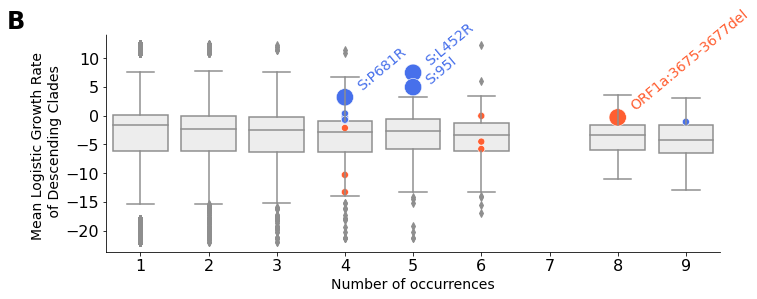

In [127]:
fig3b(100,filename='plots/fig3b_20210515.png')

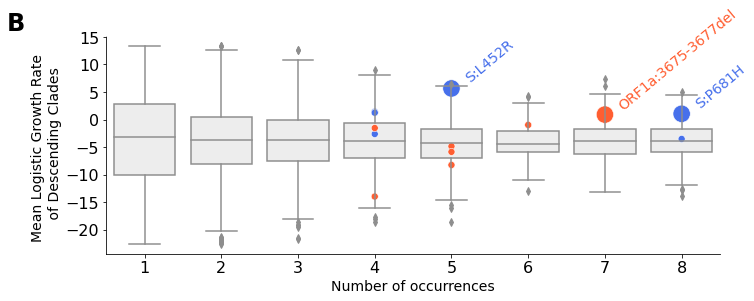

In [219]:
fig3b(100,filename='plots/fig3b_20210519.png')

In [128]:
# dictionary of list of colors for emerging lineages, depending on total number of lineages
color_palettes = {8: ['#4068CF','#5098B9','#6CB28C','#94BD62','#BFBB47','#DFA53B','#E67131','#DB2823'], 
                  9: ['#3E5DD0','#4A8CC2','#60AA9E','#80B974','#A6BE55','#CBB742','#E29D39','#E56A2F','#DB2823'], 
                  10: ['#3F52CD','#4681CA','#57A1AD','#70B487','#90BC65','#B4BD4C','#D3B240','#E59638','#E4642E','#DB2823'], 
                  11: ['#3F47C9','#4274CE','#4F97BB','#64AC99','#7EB976','#9EBE5A','#BEBB48','#D9AE3E','#E69036','#E35F2D','#DB2823'], 
                  12: ['#403CC5','#4067CF','#4A8BC3','#5AA4A9','#6FB488','#8BBB69','#A9BD53','#C7B944','#DDA93C','#E68A35','#E35C2C','#DB2823'], 
                  13: ['#4433BE','#3E5ACF','#457FCB','#529AB6','#64AD98','#7BB77A','#96BD60','#B3BD4D','#CDB642','#DFA43B','#E68434','#E2582C','#DB2823'], 
                  14: ['#492AB5','#3F4CCB','#4271CE','#4C8FC0','#5AA5A8','#6DB38A','#85BA6F','#A0BE59','#BBBC49','#D2B340','#E19F3A','#E68033','#E2562B','#DB2823'], 
                  15: ['#4D21AD','#403FC6','#3F63CF','#4783C8','#539BB5','#63AC9B','#77B67F','#8EBC66','#A8BD53','#C1BA47','#D6B03F','#E39C39','#E67C33','#E1532B','#DB2823'], 
                  16: ['#571EA2','#4334BF','#3F55CE','#4376CD','#4C91C0','#59A4A9','#6AB18F','#7FB975','#97BD5F','#AFBD4F','#C7B944','#D9AD3D','#E49838','#E67932','#E1512A','#DB2823'], 
                  17: ['#5E1D9D','#462EB9','#3F4CCB','#416CCE','#4887C6','#539CB3','#62AB9C','#74B582','#89BB6B','#A0BE59','#B7BD4B','#CCB742','#DDAA3C','#E69537','#E67631','#E14F2A','#DB2823']
                 
                 }
                      

In [137]:
def find_lineages_descending_from_muts():
    
    top_scoring_muts_df = fig3a_occurrences_vs_growth(plot=False)

    top_scoring_muts = list(top_scoring_muts_df['mutation'])

    emerging_lineages_descending_from_mut = {x:{} for x in top_scoring_muts}

    for node in tree.find_clades(terminal=True):

        emerging_lineage = node.node_attrs["emerging_lineage"]["value"]

        parents = get_parent(tree, node)

        for parent in parents:
            if len(parent.get_terminals()) >=15:

                if hasattr(parent, 'branch_attrs'):

                    for mut in top_scoring_muts:
                        gene = mut.split(':')[0]
                        mutation = mut.split(':')[1]
                        if mut=='ORF1a:3675/3676/3677del':
                            mutation = 'S3675-'
                        elif mut == 'S:69/70del':
                            mutation = 'H69-'


                        if gene in parent.branch_attrs["mutations"]:
                            if mutation in parent.branch_attrs["mutations"][gene]:
                                if parent.name in emerging_lineages_descending_from_mut[mut].keys():
                                    if emerging_lineage not in emerging_lineages_descending_from_mut[mut][parent.name]:
                                        emerging_lineages_descending_from_mut[mut][parent.name].append(emerging_lineage)
                                else:
                                    emerging_lineages_descending_from_mut[mut][parent.name] = [emerging_lineage]
                                    
    return emerging_lineages_descending_from_mut
                        

In [133]:
def convert_linege_names(old_name):
    
#     old_to_new = {'A.23.1': 'A.23.1', 'B.1.1.7': 'B.1.1.7 (Alpha)', 'B.1.351': 'B.1.351 (Beta)', 
#                   'B.1.427+B.1.429': 'B.1.427/429 (Epsilon)', 'B.1.525': 'B.1.525 (Eta)', 'B.1.526': 'B.1.526 (Iota)', 
#                   'B.1.617': 'B.1.617.1/2 (Delta/Kappa)', 
#                   'C.37': 'C.37 (Lambda)', 'P.1': 'P.1 (Gamma)', 'P.3': 'P.3', 
#                   'unassigned': 'basal'}
    
    old_to_new = {'unassigned': 'basal'}
    if old_name in old_to_new.keys():
        new_name = old_to_new[old_name]
    else:
        new_name = old_name
    
    return new_name

In [134]:
def tidy_descending_lineage_data():
    
    emerging_lineages_descending_from_mut = find_lineages_descending_from_muts()
    
    to_plot = []

    for k,v in emerging_lineages_descending_from_mut.items():
        # reformat mutation name
        mutation = k.split(':')[0]+':'+k.split(':')[1][1:]
        num_occurrences = len(v)

        for v_k, v_v in v.items():
            if len(v_v) == 1:
                descending_lineage = v_v[0]
            if len(v_v) == 2:
                if 'unassigned' in v_v:
                    v_v.remove('unassigned')
                    descending_lineage = v_v[0]
                else:
                    descending_lineage = 'multiple'
            if len(v_v) > 2:
                descending_lineage = 'multiple'
            
            to_plot.append({'mutation': mutation, 'num_occurrences': num_occurrences, 
                            'desending_lineage': convert_linege_names(descending_lineage)})

    to_plot_df = pd.DataFrame(to_plot)
    
    return to_plot_df

In [161]:
def fig3_supp1_descending_lineages(filename=False):
    
    to_plot_df = tidy_descending_lineage_data()
    
    fig, ax = plt.subplots(figsize=(6,8))
    ax.invert_yaxis()

#     possible_muts = sorted(list(to_plot_df['mutation'].unique()))
    
    # reorder dataframe to rank consistent mutations highest
    possible_muts = to_plot_df['mutation'].value_counts().index.tolist()
    
    possible_lineages = sorted(list(to_plot_df['desending_lineage'].unique()))
    possible_lineages.remove('basal')
    possible_lineages.remove('multiple')


    colors_to_use = color_palettes[len(possible_lineages)]


    cmap = dict(zip(possible_lineages, colors_to_use))
    
    possible_lineages+=['multiple', 'basal']
    cmap['basal'] = "#ABABAB"
    cmap['multiple'] = "#CBC3E3"

    x_ticks = list(range(len(possible_muts)))
    last_bars = np.array([0 for x in possible_muts])
    for y in possible_lineages:
        lineage_bars = []
        for x in possible_muts:
            lineage_bars.append(len(to_plot_df[(to_plot_df['mutation']==x) & (to_plot_df['desending_lineage']==y)]))

        plt.barh(x_ticks, lineage_bars, left=last_bars, height=0.5, color = cmap[y], edgecolor='white', label = y)
        last_bars = last_bars + np.array(lineage_bars)

    plt.yticks(x_ticks, possible_muts, rotation=40, ha='right')
    ax.set_xlabel('Independent Occurrences', fontsize = 12)
    ax.set_xlim(0, (max(last_bars))+0.5)


    handles, labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.9, 0.7))

    sns.despine(left=False, bottom=False)
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    

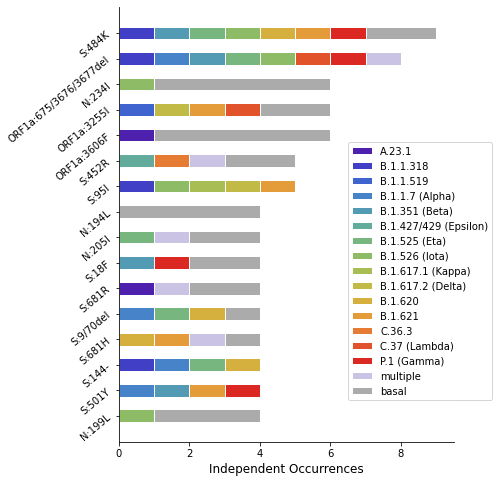

In [162]:
fig3_supp1_descending_lineages(filename='plots/fig3_supp1_20210515.png')

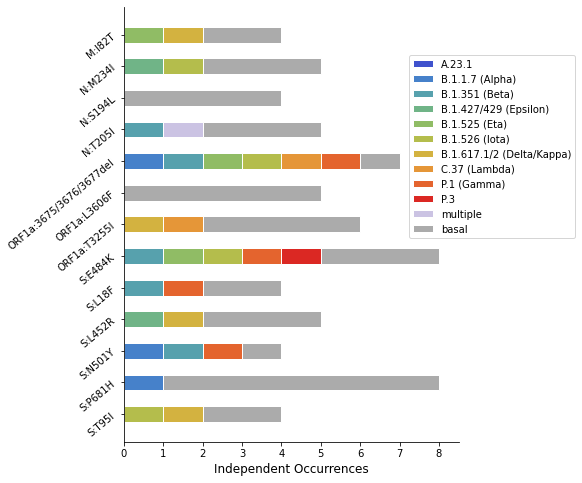

In [291]:
fig3_supp1_descending_lineages(filename='plots/fig3_supp1_20210519_new.png')

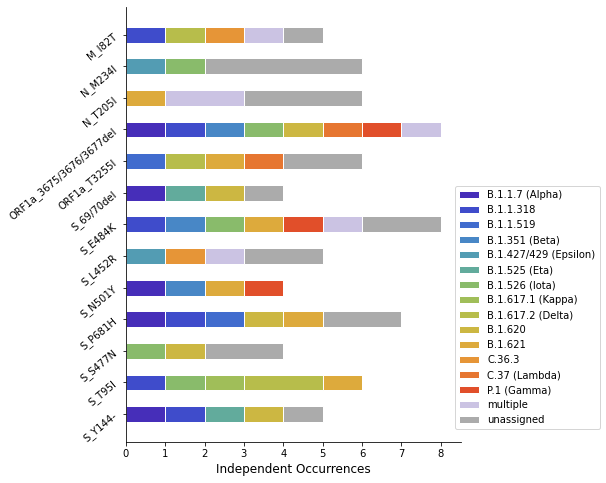

In [83]:
fig3_supp1_descending_lineages(filename='plots/fig3_supp1.png')